In [12]:
%matplotlib inline

from __future__ import print_function

import sys
import logging
from logging.config import dictConfig
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools as it
import collections as cl
import multiprocessing

from numba import jit

import pgenlib as pg

In [13]:
logging_config = dict(
    version = 1,
    formatters = {
        'f': {'format':
              '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'}
        },
    handlers = {
        'h': {'class': 'logging.StreamHandler',
              'formatter': 'f',
              'level': logging.DEBUG}
        },
    root = {
        'handlers': ['h'],
        'level': logging.DEBUG,
        },
)
dictConfig(logging_config)

In [14]:
logger_nb = logging.getLogger('notebook')
logger_nb.info('hello')

In [15]:
data_dir='/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/'
geno_bed_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10.log'
block_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-block-stronglow050-stronghigh083-infofrac10.log'
pgen_log='chr20impv1-keep-maf0005-snv-biallelic-geno01-hwe1e-10-pg.log'
pgen_f = '{}{}.pgen'.format(data_dir, pgen_log[:-4])
block_bed_f = '{}{}.bed'.format(data_dir, block_log[:-4])

In [17]:
with pg.PgenReader(pgen_f) as pg_test:
    print(pg_test.hardcall_phase_present())

False


In [5]:
block_bed = pd.read_csv(block_bed_f, sep='\t', names=['chrom', 'chromStart', 'chromEnd', 'name'])
block_bed['bim_interval'] = block_bed.name.map(lambda x: [int(pos) for pos in x.split(':')])

block_bed.head()

,chrom,chromStart,chromEnd,name,bim_interval
0,chr20,61097,94951,0:78,"[0, 78]"
1,chr20,94951,266791,78:915,"[78, 915]"
2,chr20,266791,288775,915:991,"[915, 991]"
3,chr20,288775,344630,991:1218,"[991, 1218]"
4,chr20,344630,346675,1218:1224,"[1218, 1224]"


In [10]:
def read_alleles_block(pgen_f, block_df, block_id):
    """wrapper function of pgen.PgenReader.read_alleles_range for a LD block"""
    bim_interval = block_df.bim_interval[block_id]
    with pg.PgenReader(pgen_f) as pgr:
        buf_ndary = np.zeros(
            (bim_interval[1] - bim_interval[0], pgr.get_raw_sample_ct() * 2), 
            dtype=np.int32
        )
        pgr.read_alleles_range(bim_interval[0], bim_interval[1], buf_ndary)
    return buf_ndary

def filter_missing_alleles(geno):
    return geno[:, np.sum(geno == -9, axis = 0) == 0]

def count_alleles_freq(geno):
    tuples = [tuple(1 - geno[:, hap])
              for hap in range(geno.shape[1])]
    return cl.Counter(tuples)

def prior_count(pgen_f, block_df, block_id):
    logger_cnt = logging.getLogger('prior_count')    
    geno = filter_missing_alleles(
        read_alleles_block(pgen_f, block_df, block_id)
    )        
    cnt = count_alleles_freq(geno)
    logger_cnt.info(
        'block {:3d}; {} bytes; {}; {}'.format(
            block_id, sys.getsizeof(cnt), geno.shape, len(cnt)
        )
    )    
    return cnt    

In [11]:
cnt0= prior_count(pgen_f, block_bed, 0)

2017-06-26 17:08:00,682 prior_count  INFO     block   0; 196904 bytes; (78, 119900); 4833


In [8]:
cnt0_keys = np.array(cnt0.keys(), dtype=np.int8)

In [9]:
cnt0_vals = np.array(cnt0.values())

In [10]:
cnt0_keys.shape

(4885, 79)

In [11]:
cnt0_vals.shape

(4885,)

In [12]:
np.savez(
    '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/tmp/cnt0.npz', 
    keys = cnt0_keys, vals = cnt0_vals
)

In [13]:
len(block_bed)

642

## the following sections are draft

In [14]:
cnt626= prior_count(pgen_f, block_bed, 626)

2017-06-26 15:38:42,633 prior_count  INFO     block 626 12584 bytes


In [15]:
cnt627= prior_count(pgen_f, block_bed, 627)

2017-06-26 15:38:49,449 prior_count  INFO     block 627 3146024 bytes


In [16]:
cnt627= prior_count(pgen_f, block_bed, 641)

2017-06-26 15:39:00,535 prior_count  INFO     block 641 786728 bytes


In [21]:
np.sum(cnt0_vals)

117866

In [23]:
(1+1)/2

1

In [34]:
pgw = pg.PgenWriter(
    '/oak/stanford/groups/mrivas/users/ytanigaw/nanopore-data/tmp/cnt0-pg.pgen',
    int((len(cnt0) + 1)/2), cnt0_keys.shape[1], nonref_flags=True
)

In [ ]:
for i in range(cnt0_keys.shape[1]):
    pgw.append_alleles(cnt0_keys[:, i], all_phased = True)

In [33]:
pgw.close()

RuntimeError: PgenWriter.close() called when number of written variants (1) unequal to initially declared value (86).

117866 individuals; 5144 unique haplotypes. Top 10 common haplotypes are:
[ '11111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111110111111101110111111111111011111111111110111111111111111111111111'
 '11111111111111111111111111111011111111111111111101111111111111111111111111111111111111'
 '11111111111111111111111111111111111111111111111011111111111110111111111111111111111111'
 '11111111111111111111110111111101111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111011111111111111111111111111111111111111111111111111111111'
 '11111111111111011111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111101111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111101111111111111111011111111111110111111111111111111111111'
 '11111111111111111111011111111011111111111111111111111111111111111111111111111111111111']
[17919, 3388, 3105, 3013

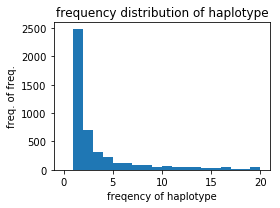

In [27]:
debug_dump_count(c_0)

In [23]:
geno_0.shape, geno_filtered_0.shape

((86, 224676), (86, 117866))

In [9]:
geno = geno_0

In [10]:
geno_isMissing = geno == -9

In [11]:
np.sum(np.sum(geno_isMissing, axis = 0) == 0)

117866

In [13]:
geno.shape

(86, 224676)

In [14]:
len(np.sum(geno_isMissing, axis = 0) == 0)

224676

In [17]:
geno_filtered = geno[:, np.sum(geno == -9, axis = 0) == 0]

In [18]:
geno_filtered.shape

(86, 117866)

In [14]:
def read_haplotype_freq(pgen_f, block_df, block_id):
    """read haplotype frequency of a given block from a pgen file"""
    bim_interval = block_df.bim_interval[block_id]
    with pg.PgenReader(pgen_f) as pgr:
        buf_ndary = np.zeros(
            (bim_interval[1] - bim_interval[0], pgr.get_raw_sample_ct() * 2), 
            dtype=np.int32
        )
        pgr.read_alleles_range(bim_interval[0], bim_interval[1], buf_ndary)
    #buf_ndary[buf_ndary == -9] = 0
    buf_tpls = [tuple(1 - buf_ndary[:, hap]) for hap in range(buf_ndary.shape[1])]
    return cl.Counter(buf_tpls), buf_ndary

In [26]:
def debug_dump_count(c):
    print('{} individuals; {} unique haplotypes. Top 10 common haplotypes are:'.format(sum(c.values()), len(c.values())))
    print(np.array([''.join([str(x) for x in c.most_common()[i][0]]) for i in range(10)]))    
    print([c.most_common()[i][1] for i in range(10)])
#     plt.hist(np.array(c.values())[np.array(c.values()) <= 20], bins=range(21))
    freq=np.array(c.values())
    fig = plt.figure(figsize=(4, 3))
    gs = gridspec.GridSpec(1, 1)
    axs = [fig.add_subplot(ss) for ss in gs]
    axs[0].hist(freq[freq <= 20], bins=range(21))
    axs[0].set_xlabel('freqency of haplotype')
    axs[0].set_ylabel('freq. of freq.')
    axs[0].set_title('frequency distribution of haplotype')
#     fig.suptitle('')
    gs.tight_layout(fig, rect=[0, 0, 1, 1])
#     fig.savefig('./fig.png')

In [15]:
c0, c0_nd = read_haplotype_freq(pgen_f, block_bed, 0)

In [17]:
c0_nd_mis = [c0_nd == -9]

In [ ]:
c0_nd_mis = 

224676 individuals; 30236 unique haplotypes. Top 10 common haplotypes are:
[ '11111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111011111110111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111111111111111111111111111101111111111111011111111111111111'
 '11111111111111111111111111111101111111111111111111111110111111111111111111111111111111'
 '11111111111111111111111111111110111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111011111110111011111001111111111101111111111111011111111111111111'
 '11111111111111101111111111111111111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111101111111111111111111111111111111111111111111111111111111'
 '11111111111111111111111111111111111111111111111111110111111111111111111111111111111111'
 '11111111111111111111111111111111111111111011111111111111111111111111111111111111111111']
[31555, 5764, 4331, 403

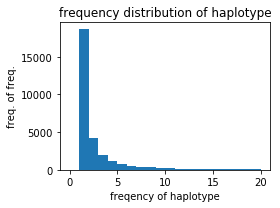

In [9]:
debug_dump_count(c0)

In [10]:
c2 = read_haplotype_freq(pgen_f, block_bed, 2)

224676 individuals; 19835 unique haplotypes. Top 10 common haplotypes are:
['1111111111111111111111111111111111111111111111111111111111111111111111'
 '1111111111111111101111011111101001111111111111111001111111111111101111'
 '0000101000001010110011111110111111100100101111111111101111001110110011'
 '1111111111111111111111111111111111111111111111110111111111111111111111'
 '1111111111111111111111111111111111111111111111111111101111101111110011'
 '1111111111111111111111111111111111111111111111111111111111111110111111'
 '1111111111111111111111111111111111111111111111111001111111111111101111'
 '0000101000001010100011011110101001100100101111111001101111001110100011'
 '1111111111111111101111011111101001111111111111110001111111111111101111'
 '1111111111111111101111011111101001111111111111111111111111111111111111']
[31830, 5944, 5797, 4455, 4060, 3225, 3221, 3213, 2892, 2825]


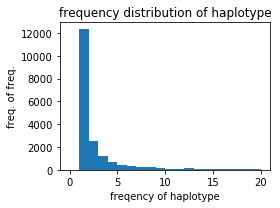

In [11]:
debug_dump_count(c2)

In [12]:
c3 = read_haplotype_freq(pgen_f, block_bed, 3)

224676 individuals; 131281 unique haplotypes. Top 10 common haplotypes are:
[ '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110111111111111111'
 '1111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
 '111111111111111111111011011111111111111111111111111111111111

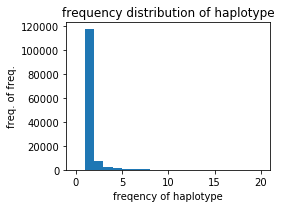

In [13]:
debug_dump_count(c3)